In [1]:
setwd('/import/hd//sc')

In [2]:
getwd()

[1] "/import/hd/sc"

In [3]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [9]:
scRNA = readRDS('./scRNA.fibro.rds')

In [10]:
Idents(scRNA) = 'celltype'

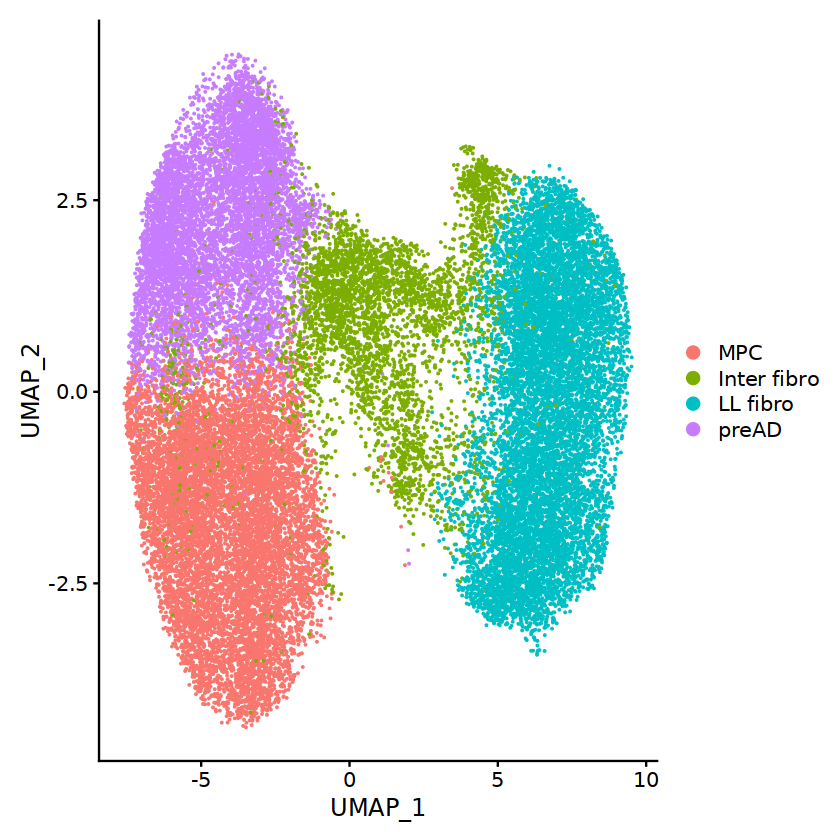

In [11]:
DimPlot(scRNA)

In [12]:
DefaultAssay(scRNA) = 'RNA'

Warning message:
"Scaling data with a low number of groups may produce misleading results"


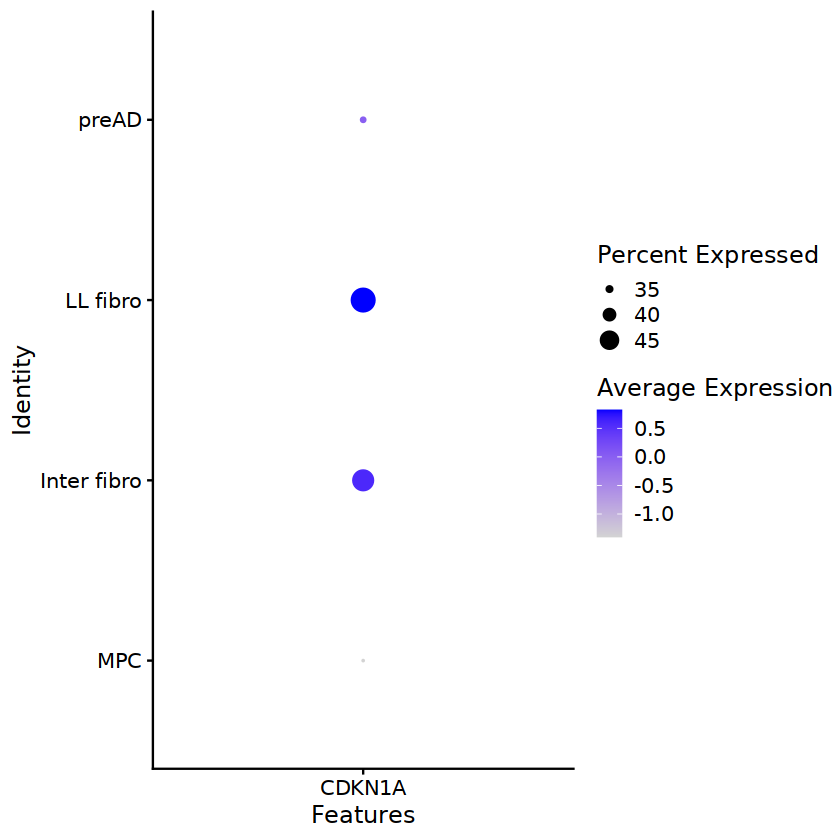

In [13]:
DotPlot(scRNA,features = 'CDKN1A')

In [16]:
d = '/import/DB' 
gmtfs <- list.files(d,pattern = '.gmt')  # 路径下所有结尾为symbols.gmt文件
gmtfs
library(GSEABase)
kegg_list <- getGmt(file.path(d,gmtfs[3])) 
go_list <- getGmt(file.path(d,gmtfs[1])) 
hall_list <- getGmt(file.path(d,gmtfs[2])) 

[1] "BP.gmt"                   "h.all.v7.5.1.symbols.gmt"
[3] "kegg.gmt"

Warning message in getGmt(file.path(d, gmtfs[1])):
"2 record(s) contain duplicate ids: GOBP_CIRCULATORY_SYSTEM_DEVELOPMENT, GOBP_PROTEOLYSIS_INVOLVED_IN_PROTEIN_CATABOLIC_PROCESS"


In [17]:
kegg_list <- getGmt('/import/code/babo/hd2/Total_kegg.gmt') 

Warning message in getGmt("/import/code/babo/hd2/Total_kegg.gmt"):
"28 record(s) contain duplicate ids: Alzheimer disease, Amyotrophic lateral sclerosis, ..., Spliceosome, Starch and sucrose metabolism"


### kegg

In [18]:
Idents(scRNA) = 'celltype'

In [19]:
table(scRNA$celltype)


Inter fibro    LL fibro         MPC       preAD 
       4492       10725       10184        7765 

In [20]:
scRNA1 = subset(scRNA,idents = 'LL fibro')
table(scRNA1$celltype,scRNA1$group)
scRNA1$cells = scRNA1$group

          
           Healthy   OA
  LL fibro    4892 5833

In [23]:
library(GSVA)
library(tidyverse)
library(org.Hs.eg.db)
Idents(scRNA1) <- "cells" 
expr <- AverageExpression(scRNA1, assays = "RNA", slot = "data")[[1]]
expr <- expr[rowSums(expr)>0,]  #过滤细胞表达量全为零的基因
expr <- as.matrix(expr)

In [24]:
colnames(expr)

[1] "OA"      "Healthy"

In [106]:
getwd()

[1] "/import/hd/sc"

In [92]:
library(msigdbr)
msigdbr_species() #列出有的物种
# #选择基因集合
# human_KEGG = msigdbr(species = "Homo sapiens", #物种
#                       category = "C2",
#                      subcategory = "KEGG") %>% 
#   dplyr::select(gs_name,gene_symbol)#这里可以选择gene symbol或者ID
# human_KEGG_Set = human_KEGG %>% split(x = .$gene_symbol, f = .$gs_name)
human_KEGG_Set = kegg_list
library(GSVA)
gsva.kegg <- gsva(expr, gset.idx.list = human_KEGG_Set, 
             kcdf="Poisson", #Poisson  Gaussian
             method = "gsva",  # gsva
             parallel.sz=1)
head(gsva.kegg)

species_name,species_common_name
<chr>,<chr>
Anolis carolinensis,"Carolina anole, green anole"
Bos taurus,"bovine, cattle, cow, dairy cow, domestic cattle, domestic cow, ox, oxen"
Caenorhabditis elegans,NA
Canis lupus familiaris,"dog, dogs"
Danio rerio,"leopard danio, zebra danio, zebra fish, zebrafish"
Drosophila melanogaster,fruit fly
Equus caballus,"domestic horse, equine, horse"
Felis catus,"cat, cats, domestic cat"
Gallus gallus,"bantam, chicken, chickens, Gallus domesticus"


Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."


Estimating GSVA scores for 346 gene sets.
Estimating ECDFs with Poisson kernels
  |======================================================================| 100%



,OA,Healthy
Glycolysis / Gluconeogenesis,-0.26110432,-0.4292941
Citrate cycle (TCA cycle),-0.45513905,-0.6659822
Pentose and glucuronate interconversions,-0.08476527,-0.4904352
Fructose and mannose metabolism,-0.37906912,-0.3233568
Galactose metabolism,-0.16398819,-0.4855678
Ascorbate and aldarate metabolism,-0.39899617,-0.5419203


In [93]:
gsva.kegg = gsva.kegg[grep('pathway',rownames(gsva.kegg),value = T),]

In [94]:
a = c()
ds = as.data.frame(gsva.kegg) 
for (i in 1:dim(ds)[2] ){
    path = ds[ order (-ds[,i]),] %>%  head(20) %>%  rownames()
    a = unique(c(a,path))
 }
gsva.kegg = gsva.kegg[a,]
options(repr.plot.width = 9,repr.plot.height =  10)

In [95]:
write.csv(gsva.kegg,file = 'Fib.kegg.res.csv')

In [96]:
path = rownames(gsva.kegg)

In [97]:
save(path,file = 'fib.path.rda')

In [98]:
gsva.kegg

,OA,Healthy
Calcium signaling pathway,0.0704071782,0.04718115
cAMP signaling pathway,-0.0005204792,-0.08510297
IL-17 signaling pathway,-0.0829715787,-0.29549603
Oxytocin signaling pathway,-0.1321278162,-0.20954719
JAK-STAT signaling pathway,-0.1730711732,-0.19459305
Hippo signaling pathway,-0.1766357879,-0.21190909
Wnt signaling pathway,-0.1805901502,-0.16760471
PI3K-Akt signaling pathway,-0.1879588761,-0.25140549
PPAR signaling pathway,-0.1915096934,-0.24321323
NF-kappa B signaling pathway,-0.1929503571,-0.32835718


### hallmark

In [99]:
library(msigdbr)
msigdbr_species() #列出有的物种
# #选择基因集合
# human_KEGG = msigdbr(species = "Homo sapiens", #物种
#                       category = "C2",
#                      subcategory = "KEGG") %>% 
#   dplyr::select(gs_name,gene_symbol)#这里可以选择gene symbol或者ID
# human_KEGG_Set = human_KEGG %>% split(x = .$gene_symbol, f = .$gs_name)
human_KEGG_Set = hall_list
library(GSVA)
gsva.kegg <- gsva(expr, gset.idx.list = human_KEGG_Set, 
             kcdf="Gaussian", #Poisson  Gaussian
             method = "gsva",  # gsva
             parallel.sz=1)
head(gsva.kegg)

species_name,species_common_name
<chr>,<chr>
Anolis carolinensis,"Carolina anole, green anole"
Bos taurus,"bovine, cattle, cow, dairy cow, domestic cattle, domestic cow, ox, oxen"
Caenorhabditis elegans,NA
Canis lupus familiaris,"dog, dogs"
Danio rerio,"leopard danio, zebra danio, zebra fish, zebrafish"
Drosophila melanogaster,fruit fly
Equus caballus,"domestic horse, equine, horse"
Felis catus,"cat, cats, domestic cat"
Gallus gallus,"bantam, chicken, chickens, Gallus domesticus"


Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."


Estimating GSVA scores for 50 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



,OA,Healthy
HALLMARK_ADIPOGENESIS,0.11423131,-0.04929756
HALLMARK_ALLOGRAFT_REJECTION,0.18396341,-0.05612744
HALLMARK_ANDROGEN_RESPONSE,0.08771127,0.15877274
HALLMARK_ANGIOGENESIS,0.30117392,-0.13607154
HALLMARK_APICAL_JUNCTION,0.04640224,-0.16913477
HALLMARK_APICAL_SURFACE,-0.11573608,-0.13350542


In [100]:
a = c()
ds = as.data.frame(gsva.kegg) 
for (i in 1:dim(ds)[2] ){
    path = ds[ order (-ds[,i]),] %>%  head(20) %>%  rownames()
    a = unique(c(a,path))
 }
gsva.kegg = gsva.kegg[a,]
options(repr.plot.width = 9,repr.plot.height =  10)

In [101]:
rownames(gsva.kegg) = gsub('HALLMARK_','',rownames(gsva.kegg))
rownames(gsva.kegg) = tolower(rownames(gsva.kegg))

In [102]:
gsva.kegg

,OA,Healthy
epithelial_mesenchymal_transition,0.39183514,-0.2336763063
tnfa_signaling_via_nfkb,0.35697492,-0.2566539977
pancreas_beta_cells,0.34724501,-0.1116088293
interferon_alpha_response,0.34377022,-0.1161899004
il2_stat5_signaling,0.30517999,-0.0558456211
glycolysis,0.30364469,-0.1480082909
angiogenesis,0.30117392,-0.1360715400
uv_response_dn,0.28416989,0.1969814103
inflammatory_response,0.27106608,-0.0903809412
interferon_gamma_response,0.26686550,-0.1494260293


In [103]:
path2 = rownames(gsva.kegg)

In [104]:
save(path2,file = 'fib.path2.rda')

In [105]:
write.csv(gsva.kegg,file = 'fib.hallmark.res.csv')

In [76]:
DefaultAssay(scRNA) = 'RNA'

In [77]:
scRNA$ss  = paste0(scRNA$celltype,'_',scRNA$group)

In [78]:
Idents(scRNA) = 'ss'

In [89]:
options(repr.plot.height = 4,repr.plot.width = 7)

In [90]:
DefaultAssay(scRNA) = 'RNA'

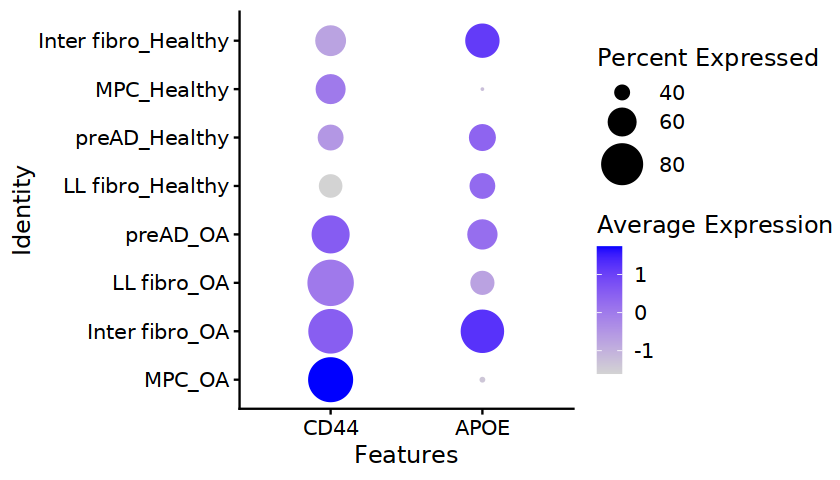

In [91]:
DotPlot(scRNA,features = c('CD44','APOE'),dot.scale = 12)